### 0. Import libraries

In [1]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *

C:\Users\denni\AppData\Local\Temp\ipykernel_4876\4151715977.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Define model

In [2]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_feature_size = dynamic_feature_size
        self.static_feature_size = static_feature_size
        self.hidden_size = hidden_size
        print(hidden_size,self.hidden_size,type(hidden_size),type(self.hidden_size))
        # LSTM module for dynamic features
        self.dynamic_rnn = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size + static_feature_size, hidden_size)  
        self.relu = nn.ReLU() 
        
        # Second Fully connected layer
        self.fc2 = nn.Linear(hidden_size, 3)
    
    def forward(self, dynamic_features, static_features):
        # Pass dynaamic features through LSTM
        _, (h_n, _) = self.dynamic_rnn(dynamic_features)
        h_n = h_n.squeeze(0)  
        
        # Concatenate dynamic features with static features
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
         # Pass concatenated features through first fully connected layer
        x = self.relu(self.fc1(concatenated_features))  

        # Pass through the second fully connected layer
        output = self.fc2(x)

        return output

## 2. Define training class


In [3]:
class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        self.loss_fn = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.learning_rate = learning_rate
    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)

        loss = self.loss_fn(y_pred.float(), y_true.float())  
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss
    """"
    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        y_pred_log = nn.functional.log_softmax(y_pred, dim=-1)
        val_loss = self.loss_fn(y_pred_log, y_true)
        self.log('val_loss', val_loss)
        self.validation_losses.append(val_loss.item())
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        y_pred_log = nn.functional.log_softmax(y_pred, dim=-1)
        test_loss = self.loss_fn(y_pred_log, y_true)
        self.log('test_loss', test_loss)
        self.test_losses.append(test_loss.item())
        return test_loss
    """
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [12]:
class SolarPanelDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file, converters={
            'temperature_sequence': ast.literal_eval, 
            'wind_speed_sequence': ast.literal_eval, 
            'dni_sequence': ast.literal_eval, 
            'dhi_sequence': ast.literal_eval, 
            'global_irradiance_sequence': ast.literal_eval, 
            'gaussian_params': lambda x: [float(i) for i in x.strip('[]').split()]
        })
        
        # Label encoding for categorical variables
        self.encoder_panel = LabelEncoder()
        self.encoder_module = LabelEncoder()
        #self.data_frame['panel_type'] = self.encoder_panel.fit_transform(self.data_frame['panel_type'])
        self.data_frame['module_type'] = self.encoder_module.fit_transform(self.data_frame['module_type'])

        # Normalize static and dynamic features
        self.normalize_features()

        # Normalize outputs and store normalization parameters
        self.output_means = []
        self.output_stds = []
        self.normalize_outputs()

    def normalize_features(self):
        # Normalize static numeric features
        for feature in ['tilt', 'azimuth']:
            mean = self.data_frame[feature].mean()
            std = self.data_frame[feature].std()
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            std = col_data.std()
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        gaussian_array = np.array(self.data_frame['gaussian_params'].tolist())
        self.output_mins = gaussian_array.min(axis=0)
        self.output_maxs = gaussian_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (gaussian_array - self.output_mins) / range
        self.data_frame['gaussian_params'] = list(normalized_gaussian)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][[ 'tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features)
        
        # Dynamic features 
        dynamic_features = np.column_stack([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features)

        # Gaussian parameters as output, normalized
        outputs = torch.tensor(self.data_frame.iloc[idx]['gaussian_params'])

        return dynamic_features, static_features, outputs

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output.numpy() * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output

# Example usage
#dataset = SolarPanelDataset('energy_data/model_input.csv')
dataset = SolarPanelDataset('energy_data/dataset_to_train_model.csv')
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

for i, data in enumerate(data_loader):
    if i > 16:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) # Gaussian: Amplitude, Mean, standard deviation (normalized)

    # Example to denormalize the output for the first batch
    #if i == 0:
    #    denormalized_outputs = [dataset.denormalize_output(output) for output in outputs]
    #     print("Denormalized Outputs:", denormalized_outputs)


Static Inputs: tensor([[ 0.3287, -0.3402,  0.0000],
        [ 0.2288,  0.9707,  1.0000],
        [ 0.6795, -0.4900,  1.0000],
        [ 1.4897,  0.3128,  0.0000],
        [-0.0806,  0.7915,  1.0000],
        [ 2.5516,  0.9989,  0.0000],
        [-2.4221,  1.0661,  1.0000],
        [-1.6838, -0.9030,  0.0000],
        [ 0.5884,  0.3228,  0.0000],
        [ 0.6795, -0.4900,  1.0000]])
Dynamic Inputs Shape: torch.Size([10, 24, 5])
Outputs: tensor([[0.3424, 0.6656, 0.5988],
        [0.4196, 0.7220, 0.5911],
        [0.3056, 0.6584, 0.6144],
        [0.4902, 0.6192, 0.6892],
        [0.3625, 0.6667, 0.6273],
        [0.3308, 0.7197, 0.6299],
        [0.5355, 0.5866, 0.5520],
        [0.4461, 0.6967, 0.6061],
        [0.3692, 0.6987, 0.5887],
        [0.3859, 0.6019, 0.8118]], dtype=torch.float64)
Static Inputs: tensor([[ 0.1394, -0.3794,  0.0000],
        [ 0.5246, -0.0183,  0.0000],
        [ 0.4267,  0.7527,  0.0000],
        [ 1.0420, -0.5914,  1.0000],
        [ 0.7585, -1.2502,  0.0000

## 4. Train model

In [16]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 3
hidden_size = 128
learning_rate = 1e-2

# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size, learning_rate)
model = train_module.model 
print(model)
#print(summary(model, [(dynamic_feature_size,), (static_feature_size,)]))

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=1, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 86.4 K
1 | loss_fn | MSELoss               | 0     
--------------------------------------------------
86.4 K    Trainable params
0         Non-trainable params
86.4 K    Total params
0.346     Total estimated model params size (MB)


128 128 <class 'int'> <class 'int'>
EnergyPredictionModel(
  (dynamic_rnn): LSTM(5, 128, batch_first=True)
  (fc1): Linear(in_features=131, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Log directory contents: ['version_10', 'version_11', 'version_12', 'version_13', 'version_14', 'version_15', 'version_16', 'version_17', 'version_18', 'version_19', 'version_20', 'version_21', 'version_22', 'version_23', 'version_24', 'version_25', 'version_26', 'version_27', 'version_28', 'version_29', 'version_30', 'version_31', 'version_32', 'version_33', 'version_34', 'version_35', 'version_36', 'version_37', 'version_38', 'version_39', 'version_40', 'version_41', 'version_42', 'version_43', 'version_44', 'version_45', 'version_46', 'version_47', 'version_48', 'version_49', 'version_50', 'version_51', 'version_52', 'version_53', 'version_54', 'version_55', 'version_56', 'version_57', 'version_58', 'version_59', 'version_6', 'version_60', 

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## 5. Inspect performance

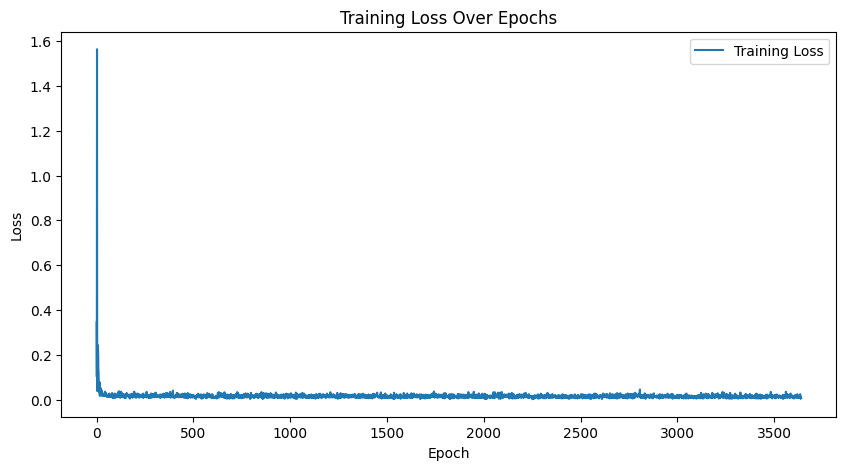

0.3440474271774292
0.10211222618818283
1.5638874769210815
0.03824113309383392
0.11710970103740692
0.2232472449541092
0.1900232881307602
0.24238242208957672
0.20410315692424774
0.13631154596805573
0.1239112839102745
0.0794077217578888
0.03226086124777794
0.03818199411034584
0.066740483045578
0.07862202078104019
0.01896740309894085
0.01658632420003414
0.042060695588588715
0.03961847350001335
0.05238640308380127
0.029385773465037346
0.027951622381806374
0.03179067745804787
0.01864258013665676
0.018039798364043236
0.04030262678861618
0.038554929196834564
0.030557382851839066
0.026949383318424225
0.01949341967701912
0.018020791932940483
0.023266799747943878
0.025868237018585205
0.016582129523158073
0.015717091038823128
0.01825164072215557
0.019820576533675194
0.021178951486945152
0.01557036954909563
0.018695278093218803
0.01930467039346695
0.020138714462518692
0.035170529037714005
0.016972001641988754
0.019023576751351357
0.03045801632106304
0.023225747048854828
0.0275734830647707
0.0252726

In [17]:
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

for i in  train_module.train_losses:
    print(i)


#### Launch tensorboard for advanced training insights

In [130]:
#Launch tensorboard for advanced training insights.
os.system(f"taskkill /pid 19988 /F")

# Reload the TensorBoard extension to avoid errors about it being already loaded
%reload_ext tensorboard

# Start TensorBoard
%tensorboard --logdir tb_logs/my_model

Reusing TensorBoard on port 6007 (pid 19988), started 8 days, 20:23:23 ago. (Use '!kill 19988' to kill it.)

### Use model

In [1]:
# Load the trained model
trained_model = train_module 
trained_model.eval() 

# Get a single sample from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(data_loader))
sample =5
# Predict using a single example
with torch.no_grad():
    predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
print(predictions,predictions.shape)

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves
def plot_gaussian(x, predictions,ground_truth, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, label in enumerate(labels):
        a, b, c = predictions[i]
        y = gaussian(x, a, b, c)
        ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
     # Plot ground truth Gaussian curves
    gt_a, gt_b, gt_c = ground_truth[0]
    gt_y = gaussian(x, gt_a, gt_b, gt_c)
    ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

    ax.set_title('Gaussian Curves for Predicted Outputs')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Gaussian Value')
    ax.legend()
    plt.show()

# Prepare x-axis for the plot
x_values = np.linspace(-10, 30, 400)

# Reshape predictions if necessary and convert to numpy if still in tensor form
predictions = predictions.squeeze().numpy().reshape(1, -1)
predictions = predictions
print(predictions, predictions.shape)
ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# Plot the Gaussian curve for the predicted values
plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])

NameError: name 'train_module' is not defined